<a href="https://colab.research.google.com/github/ramya1807/Hospital-Playlist/blob/main/Text_Processing_and_XLNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Suzanne

**Data files:**



*    Extracted twitter data that has undergone an initial round of pre-processing (in R) to convert emoticons and unicode strings to text equivalents
*    Pre-split into 70% train data and 30% test data
     *   train_textcleaned.csv
     *   test_textcleaned.csv



# Preliminary

## Import libraries

In [2]:
import pandas as pd # library for reading csv files
import random

## For Pre-processing
import re
import string
import nltk    # nlp library
from nltk.stem import WordNetLemmatizer   # importing the Lemmatization function from nltk library
from nltk.tokenize.treebank import TreebankWordDetokenizer # for detokenization


## For XLNet
!pip install Sentencepiece
!pip install transformers

import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.6 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 71.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Load data

In [3]:
traindata = pd.read_csv('train_textcleaned.csv') # loading dataset
testdata = pd.read_csv('test_textcleaned.csv') 

traindata.head()

Unnamed: 0                                              tweet  label
0           1  New Alzheimer Society resources to support a m...      1
1           4  Hippocampus ! If this part are damage we could...      1
2           5  How tackling hearing loss could reduce your ri...      1
3           6  Finding the fun in the fog of Alzheimer’s via ...      1
4           8  A family of 6 drowned in a van. 2 adults (with...      1

# Pre-processing

Reference: https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

In [4]:
data = traindata[['tweet', 'label']]
data.head()

tweet  label
0  New Alzheimer Society resources to support a m...      1
1  Hippocampus ! If this part are damage we could...      1
2  How tackling hearing loss could reduce your ri...      1
3  Finding the fun in the fog of Alzheimer’s via ...      1
4  A family of 6 drowned in a van. 2 adults (with...      1

## Remove punctuation

In [5]:
# defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

# storing the punctuation free text
data['tweet_clean']= data['tweet'].apply(lambda x:remove_punctuation(x))
data.head()

tweet  label  \
0  New Alzheimer Society resources to support a m...      1   
1  Hippocampus ! If this part are damage we could...      1   
2  How tackling hearing loss could reduce your ri...      1   
3  Finding the fun in the fog of Alzheimer’s via ...      1   
4  A family of 6 drowned in a van. 2 adults (with...      1   

                                         tweet_clean  
0  New Alzheimer Society resources to support a m...  
1  Hippocampus  If this part are damage we could ...  
2  How tackling hearing loss could reduce your ri...  
3  Finding the fun in the fog of Alzheimer’s via ...  
4  A family of 6 drowned in a van 2 adults with A...

## Remove numbers

In [6]:
# defining function to remove numbers

def remove_numbers(text):
    numbersfree = re.sub(r'\d+', '', text)
    return numbersfree

# storing the number free text
data['tweet_clean']= data['tweet_clean'].apply(lambda x:remove_numbers(x))
data.head()  

tweet  label  \
0  New Alzheimer Society resources to support a m...      1   
1  Hippocampus ! If this part are damage we could...      1   
2  How tackling hearing loss could reduce your ri...      1   
3  Finding the fun in the fog of Alzheimer’s via ...      1   
4  A family of 6 drowned in a van. 2 adults (with...      1   

                                         tweet_clean  
0  New Alzheimer Society resources to support a m...  
1  Hippocampus  If this part are damage we could ...  
2  How tackling hearing loss could reduce your ri...  
3  Finding the fun in the fog of Alzheimer’s via ...  
4  A family of  drowned in a van  adults with Alz...

## Convert to lowercase

In [7]:
# convert all to lowercase letters
data['tweet_clean']= data['tweet_clean'].apply(lambda x: x.lower())
data.head()

tweet  label  \
0  New Alzheimer Society resources to support a m...      1   
1  Hippocampus ! If this part are damage we could...      1   
2  How tackling hearing loss could reduce your ri...      1   
3  Finding the fun in the fog of Alzheimer’s via ...      1   
4  A family of 6 drowned in a van. 2 adults (with...      1   

                                         tweet_clean  
0  new alzheimer society resources to support a m...  
1  hippocampus  if this part are damage we could ...  
2  how tackling hearing loss could reduce your ri...  
3  finding the fun in the fog of alzheimer’s via ...  
4  a family of  drowned in a van  adults with alz...

## Tokenization

In [8]:
# defining function for tokenization

def tokenization(text):
    tokens = re.split(r'\s+', text)
    return tokens

# applying function to the column
data['tweet_token']= data['tweet_clean'].apply(lambda x: tokenization(x))

data.head()

tweet  label  \
0  New Alzheimer Society resources to support a m...      1   
1  Hippocampus ! If this part are damage we could...      1   
2  How tackling hearing loss could reduce your ri...      1   
3  Finding the fun in the fog of Alzheimer’s via ...      1   
4  A family of 6 drowned in a van. 2 adults (with...      1   

                                         tweet_clean  \
0  new alzheimer society resources to support a m...   
1  hippocampus  if this part are damage we could ...   
2  how tackling hearing loss could reduce your ri...   
3  finding the fun in the fog of alzheimer’s via ...   
4  a family of  drowned in a van  adults with alz...   

                                         tweet_token  
0  [new, alzheimer, society, resources, to, suppo...  
1  [hippocampus, if, this, part, are, damage, we,...  
2  [how, tackling, hearing, loss, could, reduce, ...  
3  [finding, the, fun, in, the, fog, of, alzheime...  
4  [a, family, of, drowned, in, a, van, adults, w...

## Remove stopwords

In [9]:
#Stop words present in the library
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords[0:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [10]:
# defining the function to remove stopwords from tokenized text

def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

# applying the function
data['no_stopwords']= data['tweet_token'].apply(lambda x:remove_stopwords(x))

data.head()

tweet  label  \
0  New Alzheimer Society resources to support a m...      1   
1  Hippocampus ! If this part are damage we could...      1   
2  How tackling hearing loss could reduce your ri...      1   
3  Finding the fun in the fog of Alzheimer’s via ...      1   
4  A family of 6 drowned in a van. 2 adults (with...      1   

                                         tweet_clean  \
0  new alzheimer society resources to support a m...   
1  hippocampus  if this part are damage we could ...   
2  how tackling hearing loss could reduce your ri...   
3  finding the fun in the fog of alzheimer’s via ...   
4  a family of  drowned in a van  adults with alz...   

                                         tweet_token  \
0  [new, alzheimer, society, resources, to, suppo...   
1  [hippocampus, if, this, part, are, damage, we,...   
2  [how, tackling, hearing, loss, could, reduce, ...   
3  [finding, the, fun, in, the, fog, of, alzheime...   
4  [a, family, of, drowned, in, a, van, adults, w...   

                                        no_stopwords  
0  [new, alzheimer, society, resources, support, ...  
1  [hippocampus, part, damage, could, get, dement...  
2  [tackling, hearing, loss, could, reduce, risk,...  
3  [finding, fun, fog, alzheimer’s, via, irishtimes]  
4  [family, drowned, van, adults, alzheimers, chi...

## Lemmatization

In [11]:
# defining the object for Lemmatization
nltk.download('omw-1.4')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

# defining a function for stemming
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

# apply
data['tweet_lemm'] = data['no_stopwords'].apply(lambda x: lemmatizer(x))

data.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


tweet  label  \
0  New Alzheimer Society resources to support a m...      1   
1  Hippocampus ! If this part are damage we could...      1   
2  How tackling hearing loss could reduce your ri...      1   
3  Finding the fun in the fog of Alzheimer’s via ...      1   
4  A family of 6 drowned in a van. 2 adults (with...      1   

                                         tweet_clean  \
0  new alzheimer society resources to support a m...   
1  hippocampus  if this part are damage we could ...   
2  how tackling hearing loss could reduce your ri...   
3  finding the fun in the fog of alzheimer’s via ...   
4  a family of  drowned in a van  adults with alz...   

                                         tweet_token  \
0  [new, alzheimer, society, resources, to, suppo...   
1  [hippocampus, if, this, part, are, damage, we,...   
2  [how, tackling, hearing, loss, could, reduce, ...   
3  [finding, the, fun, in, the, fog, of, alzheime...   
4  [a, family, of, drowned, in, a, van, adults, w...   

                                        no_stopwords  \
0  [new, alzheimer, society, resources, support, ...   
1  [hippocampus, part, damage, could, get, dement...   
2  [tackling, hearing, loss, could, reduce, risk,...   
3  [finding, fun, fog, alzheimer’s, via, irishtimes]   
4  [family, drowned, van, adults, alzheimers, chi...   

                                          tweet_lemm  
0  [new, alzheimer, society, resource, support, m...  
1  [hippocampus, part, damage, could, get, dement...  
2  [tackling, hearing, loss, could, reduce, risk,...  
3  [finding, fun, fog, alzheimer’s, via, irishtimes]  
4   [family, drowned, van, adult, alzheimers, child]

## Detokenization

We detokenize after removing stopwords and applying lemmatization, in preparation for using the XLNet tokenizer.

In [12]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

# defining function for detokenization

def detokenization(text):
    detoken_text = TreebankWordDetokenizer().detokenize(text)
    return detoken_text

# applying function to the column
data['tweet_detoken']= data['tweet_lemm'].apply(lambda x: detokenization(x))

data.head()

tweet  label  \
0  New Alzheimer Society resources to support a m...      1   
1  Hippocampus ! If this part are damage we could...      1   
2  How tackling hearing loss could reduce your ri...      1   
3  Finding the fun in the fog of Alzheimer’s via ...      1   
4  A family of 6 drowned in a van. 2 adults (with...      1   

                                         tweet_clean  \
0  new alzheimer society resources to support a m...   
1  hippocampus  if this part are damage we could ...   
2  how tackling hearing loss could reduce your ri...   
3  finding the fun in the fog of alzheimer’s via ...   
4  a family of  drowned in a van  adults with alz...   

                                         tweet_token  \
0  [new, alzheimer, society, resources, to, suppo...   
1  [hippocampus, if, this, part, are, damage, we,...   
2  [how, tackling, hearing, loss, could, reduce, ...   
3  [finding, the, fun, in, the, fog, of, alzheime...   
4  [a, family, of, drowned, in, a, van, adults, w...   

                                        no_stopwords  \
0  [new, alzheimer, society, resources, support, ...   
1  [hippocampus, part, damage, could, get, dement...   
2  [tackling, hearing, loss, could, reduce, risk,...   
3  [finding, fun, fog, alzheimer’s, via, irishtimes]   
4  [family, drowned, van, adults, alzheimers, chi...   

                                          tweet_lemm  \
0  [new, alzheimer, society, resource, support, m...   
1  [hippocampus, part, damage, could, get, dement...   
2  [tackling, hearing, loss, could, reduce, risk,...   
3  [finding, fun, fog, alzheimer’s, via, irishtimes]   
4   [family, drowned, van, adult, alzheimers, child]   

                                       tweet_detoken  
0  new alzheimer society resource support move lo...  
1  hippocampus part damage could get dementia alz...  
2  tackling hearing loss could reduce risk dement...  
3         finding fun fog alzheimer’s via irishtimes  
4          family drowned van adult alzheimers child

## Pre-process test set

We will use the same pre-processing steps that were used for the training data above:


*   Remove punctuations
*   Remove numbers
*   Convert to lowercase
*   Tokenization
*   Remove stopwords
*   Lemmatization



In [13]:
test_processed = testdata[['tweet', 'label']]
test_processed['tweet_processed']= test_processed['tweet'].apply(lambda x: remove_punctuation(x))
test_processed['tweet_processed']= test_processed['tweet_processed'].apply(lambda x: remove_numbers(x))
test_processed['tweet_processed']= test_processed['tweet_processed'].apply(lambda x: x.lower())
test_processed['tweet_processed']= test_processed['tweet_processed'].apply(lambda x: tokenization(x))
test_processed['tweet_processed']= test_processed['tweet_processed'].apply(lambda x: remove_stopwords(x))
test_processed['tweet_processed']= test_processed['tweet_processed'].apply(lambda x: lemmatizer(x))
test_processed['tweet_processed']= test_processed['tweet_processed'].apply(lambda x: detokenization(x))

test_processed.head()


tweet  label  \
0         What to Know About Thyroid and Alzheimer's      1   
1  一瞬「？」でしたが、なるほどプリオンの絡みか。 Alzheimer, Parkinson D...      1   
2  Encouraging!!! Study reveals what causes Alzhe...      1   
3  Taking statins for 6 months reduces risk of Al...      1   
4  The Telegraph will give £1 to Alzheimer's Rese...      1   

                                     tweet_processed  
0                            know thyroid alzheimers  
1  一瞬「？」でしたが、なるほどプリオンの絡みか。 alzheimer parkinson di...  
2  encouraging study reveals cause alzheimers dru...  
3  taking statin month reduces risk alzheimers al...  
4  telegraph give £ alzheimers research uk every ...

# Convert Labels to Binary Columns

In [14]:
# We will only use the pre-processed data

train_text = data[['tweet_detoken', 'label']]
train_text.columns = ['tweet', 'label']

test = test_processed[['tweet_processed', 'label']]
test.columns = ['tweet', 'label']

train_text.head()
# train_text            # 3175 columns
# test_text             # 1361 columns

tweet  label
0  new alzheimer society resource support move lo...      1
1  hippocampus part damage could get dementia alz...      1
2  tackling hearing loss could reduce risk dement...      1
3         finding fun fog alzheimer’s via irishtimes      1
4          family drowned van adult alzheimers child      1

In [15]:
# Set up empty columns for each label
df = pd.DataFrame(np.zeros((3175, 4)), columns=['Non-health', 'Awareness', 'Other-mention', 'Self-mention'])

train_text = pd.concat([train_text, df], axis=1)
train_text

tweet  label  Non-health  \
0     new alzheimer society resource support move lo...      1         0.0   
1     hippocampus part damage could get dementia alz...      1         0.0   
2     tackling hearing loss could reduce risk dement...      1         0.0   
3            finding fun fog alzheimer’s via irishtimes      1         0.0   
4             family drowned van adult alzheimers child      1         0.0   
...                                                 ...    ...         ...   
3170  eye foot lip toe keep quiet stroke lick mistre...      0         0.0   
3171  watch trump vids wo soundi feel like minor str...      0         0.0   
3172                bruh almost heat stroke coming work      1         0.0   
3173                         stroke leave pussy soakin😋      0         0.0   
3174              stroke lick suck cock — drop top song      0         0.0   

      Awareness  Other-mention  Self-mention  
0           0.0            0.0           0.0  
1           0.0            0.0           0.0  
2           0.0            0.0           0.0  
3           0.0            0.0           0.0  
4           0.0            0.0           0.0  
...         ...            ...           ...  
3170        0.0            0.0           0.0  
3171        0.0            0.0           0.0  
3172        0.0            0.0           0.0  
3173        0.0            0.0           0.0  
3174        0.0            0.0           0.0  

[3175 rows x 6 columns]

In [16]:
# Loop through each entry and fill in the binary value

for row in range(0, train_text.shape[0]):            # loop through each row
  if train_text['label'][row] == 0:
    #train_text['Non-health'][row] = 1
    train_text.loc[row, ['Non-health']] = 1

  elif train_text['label'][row] == 1:
    #train_text['Awareness'][row] = 1
    train_text.loc[row, ['Awareness']] = 1

  elif train_text['label'][row] == 2:
    #train_text['Other-mention'][row] = 1
    train_text.loc[row, ['Other-mention']] = 1

  elif train_text['label'][row] == 3:
    #train_text['Self-mention'][row] = 1
    train_text.loc[row, ['Self-mention']] = 1

train_text

tweet  label  Non-health  \
0     new alzheimer society resource support move lo...      1         0.0   
1     hippocampus part damage could get dementia alz...      1         0.0   
2     tackling hearing loss could reduce risk dement...      1         0.0   
3            finding fun fog alzheimer’s via irishtimes      1         0.0   
4             family drowned van adult alzheimers child      1         0.0   
...                                                 ...    ...         ...   
3170  eye foot lip toe keep quiet stroke lick mistre...      0         1.0   
3171  watch trump vids wo soundi feel like minor str...      0         1.0   
3172                bruh almost heat stroke coming work      1         0.0   
3173                         stroke leave pussy soakin😋      0         1.0   
3174              stroke lick suck cock — drop top song      0         1.0   

      Awareness  Other-mention  Self-mention  
0           1.0            0.0           0.0  
1           1.0            0.0           0.0  
2           1.0            0.0           0.0  
3           1.0            0.0           0.0  
4           1.0            0.0           0.0  
...         ...            ...           ...  
3170        0.0            0.0           0.0  
3171        0.0            0.0           0.0  
3172        1.0            0.0           0.0  
3173        0.0            0.0           0.0  
3174        0.0            0.0           0.0  

[3175 rows x 6 columns]

In [17]:
# Set up empty columns for each label
df = pd.DataFrame(np.zeros((1361, 4)), columns=['Non-health', 'Awareness', 'Other-mention', 'Self-mention'])

test = pd.concat([test, df], axis=1)

# Loop through each entry and fill in the binary value

for row in range(0, test.shape[0]):            # loop through each row
  if test['label'][row] == 0:
    #test['Non-health'][row] = 1
    test.loc[row, ['Non-health']] = 1

  elif test['label'][row] == 1:
    #test['Awareness'][row] = 1
    test.loc[row, ['Awareness']] = 1

  elif test['label'][row] == 2:
    #test['Other-mention'][row] = 1
    test.loc[row, ['Other-mention']] = 1

  elif test['label'][row] == 3:
    #test['Self-mention'][row] = 1
    test.loc[row, ['Self-mention']] = 1

test

tweet  label  Non-health  \
0                               know thyroid alzheimers      1         0.0   
1     一瞬「？」でしたが、なるほどプリオンの絡みか。 alzheimer parkinson di...      1         0.0   
2     encouraging study reveals cause alzheimers dru...      1         0.0   
3     taking statin month reduces risk alzheimers al...      1         0.0   
4     telegraph give £ alzheimers research uk every ...      1         0.0   
...                                                 ...    ...         ...   
1356  timing carotid revascularization procedure isc...      1         0.0   
1357  mxa build fullrace cr twostroke last year crai...      0         1.0   
1358  psst stroke midnight go wish smangokat happy b...      0         1.0   
1359  noceurtitanium depends lighting joked turned s...      0         1.0   
1360  world ended stroke midnight stuck purgatory af...      0         1.0   

      Awareness  Other-mention  Self-mention  
0           1.0            0.0           0.0  
1           1.0            0.0           0.0  
2           1.0            0.0           0.0  
3           1.0            0.0           0.0  
4           1.0            0.0           0.0  
...         ...            ...           ...  
1356        1.0            0.0           0.0  
1357        0.0            0.0           0.0  
1358        0.0            0.0           0.0  
1359        0.0            0.0           0.0  
1360        0.0            0.0           0.0  

[1361 rows x 6 columns]

# XLNet Model

Reference: https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df

In [18]:
random.seed(555)

## Check GPU

In [19]:
import torch 

# Check if GPU is available
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


## Plot sentence embeddings length

In [20]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Text Embeddings");
    ax.set_ylabel("Number of Tweets");
    return

In [21]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [22]:
train_text_list = train_text["tweet"].values
test_text_list = test["tweet"].values

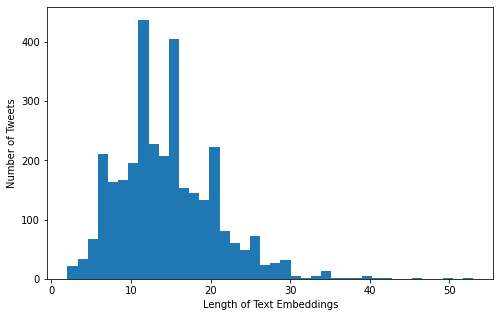

In [23]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

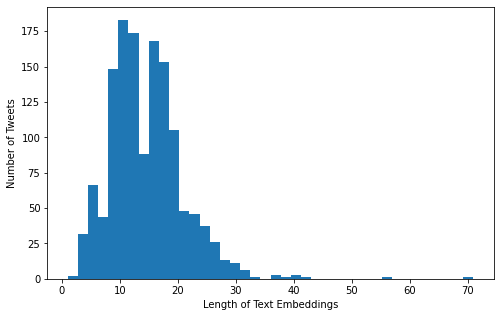

In [24]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

## Pre-processing

In [25]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

Since the tweets have less than 100 sub-words, we can truncate or pad all comments to 100 sub-words (ie. num_embeddings).

In [26]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=100)
train_input_ids

array([[  109,  1296,   553, ...,     0,     0,     0],
       [30787, 22860,   188, ...,     0,     0,     0],
       [22099,  2243,  1059, ...,     0,     0,     0],
       ...,
       [   17, 10997,   409, ...,     0,     0,     0],
       [ 7370,   755,   943, ...,     0,     0,     0],
       [ 7370,    17,  8254, ...,     0,     0,     0]])

In [27]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=100)
test_input_ids

array([[  175,  9784, 10288, ...,     0,     0,     0],
       [   17,     0,    82, ...,     0,     0,     0],
       [ 7298,   757,  9845, ...,     0,     0,     0],
       ...,
       [   17,  3716,   639, ...,     0,     0,     0],
       [  116,  1138,  1067, ...,     0,     0,     0],
       [  185,  1348,  7370, ...,     0,     0,     0]])

In [28]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
train_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

In [29]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
test_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

In [30]:
# add input ids and attention masks to the dataframe
train_text["features"] = train_input_ids.tolist()
train_text["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [31]:
train_text.head()

tweet  label  Non-health  \
0  new alzheimer society resource support move lo...      1         0.0   
1  hippocampus part damage could get dementia alz...      1         0.0   
2  tackling hearing loss could reduce risk dement...      1         0.0   
3         finding fun fog alzheimer’s via irishtimes      1         0.0   
4          family drowned van adult alzheimers child      1         0.0   

   Awareness  Other-mention  Self-mention  \
0        1.0            0.0           0.0   
1        1.0            0.0           0.0   
2        1.0            0.0           0.0   
3        1.0            0.0           0.0   
4        1.0            0.0           0.0   

                                            features  \
0  [109, 1296, 553, 22301, 1814, 3991, 309, 579, ...   
1  [30787, 22860, 188, 1696, 121, 133, 27067, 129...   
2  [22099, 2243, 1059, 121, 1820, 1046, 27067, 12...   
3  [2472, 1572, 12320, 1296, 553, 22301, 165, 23,...   
4  [273, 18411, 3887, 3639, 1296, 553, 22301, 23,...   

                                               masks  
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
3  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
4  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

## Train-Validation Split (80%-20%)

In [32]:
train, valid = train_test_split(train_text, test_size=0.2, random_state=42)

In [33]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = ["Non-health", "Awareness", "Other-mention", "Self-mention"]
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

## Create Dataloaders

In [34]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [35]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [36]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

## Train Model from Scratch

In [37]:
torch.cuda.empty_cache()

In [38]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [40]:
#num_epochs=10
num_epochs=3        # identified as the optimal number of epochs as it obtained the lowest validation loss

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "xlnet_healthtweet.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.023838253600860206
Valid loss: 0.015763905034290523


Epoch:  33%|███▎      | 1/3 [00:59<01:58, 59.10s/it]

Saving model at epoch 0 with validation loss of 0.015763905034290523


Train loss: 0.014237808902549932
Valid loss: 0.01534840597763775


Epoch:  67%|██████▋   | 2/3 [02:00<01:00, 60.66s/it]

Saving model at epoch 1 with validation loss of 0.01534840597763775


Train loss: 0.00956411943147619


Epoch: 100%|██████████| 3/3 [03:02<00:00, 60.77s/it]

Valid loss: 0.01594717815503713




Text(0.5, 1.0, 'Loss vs Number of Epochs')

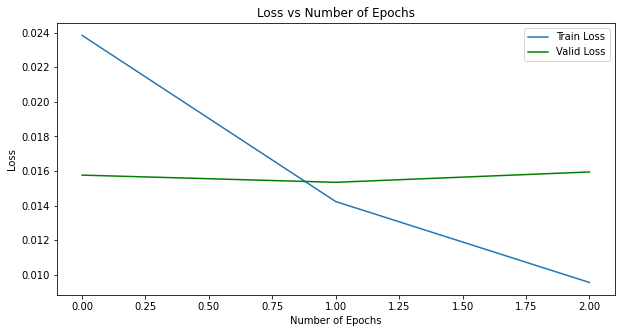

In [41]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
train_loss, = ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
valid_loss, = ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
ax.legend([train_loss, valid_loss], ['Train Loss', 'Valid Loss'])
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

# Test Model

## Get Predictions

In [42]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

### For validation set

In [43]:
num_labels = len(label_cols)
pred_probs_valid = generate_predictions(model, valid, num_labels, device="cuda", batch_size=32)
pred_probs_valid

array([[3.90867062e-04, 9.89486217e-01, 2.25855201e-03, 4.69480129e-03],
       [1.08744181e-03, 9.75049496e-01, 2.82883551e-02, 5.26880205e-04],
       [4.06448526e-04, 9.99024391e-01, 7.02039280e-04, 1.98119218e-04],
       ...,
       [9.92477834e-01, 2.83260224e-03, 1.88197172e-03, 6.63556624e-04],
       [9.85304177e-01, 1.15561020e-02, 1.23440921e-02, 1.09168608e-03],
       [6.73310645e-03, 5.98251307e-03, 9.68320608e-01, 1.26997698e-02]])

In [44]:
np.round(pred_probs_valid)

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [45]:
# store predictions in dataframe

valid["pred Non-health"] = np.round(pred_probs_valid)[:,0]
valid["pred Awareness"] = np.round(pred_probs_valid)[:,1]
valid["pred Other-mention"] = np.round(pred_probs_valid)[:,2]
valid["pred Self-mention"] = np.round(pred_probs_valid)[:,3]
valid["pred label"] = 'NA'

In [46]:
valid.head()

tweet  label  Non-health  \
2270  social medium mental illness instagram faceboo...      1         0.0   
442   see must attack alzheimers disease range resea...      1         0.0   
2885  high carb intake high death rate high fat lowe...      1         0.0   
1655                        fantasyminds cancer true 😂😂      0         1.0   
1001    playing playing im fucking heart attack btsonkj      0         1.0   

      Awareness  Other-mention  Self-mention  \
2270        1.0            0.0           0.0   
442         1.0            0.0           0.0   
2885        1.0            0.0           0.0   
1655        0.0            0.0           0.0   
1001        0.0            0.0           0.0   

                                               features  \
2270  [796, 3410, 3728, 5363, 25, 4495, 6877, 423, 3...   
442   [197, 272, 762, 1296, 553, 22301, 23, 1487, 94...   
2885  [227, 17, 20512, 12063, 227, 513, 724, 227, 32...   
1655  [8982, 19044, 23, 1847, 1229, 17, 0, 4, 3, 0, ...   
1001  [945, 945, 7693, 19021, 758, 762, 21572, 672, ...   

                                                  masks  pred Non-health  \
2270  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
442   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
2885  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
1655  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...              0.0   
1001  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              1.0   

      pred Awareness  pred Other-mention  pred Self-mention pred label  
2270             1.0                 0.0                0.0         NA  
442              1.0                 0.0                0.0         NA  
2885             1.0                 0.0                0.0         NA  
1655             1.0                 0.0                0.0         NA  
1001             0.0                 0.0                0.0         NA

In [47]:
# Loop through each entry and convert binary value to label number

valid_df = valid.reset_index()

for row in range(0, valid_df.shape[0]):            # loop through each row
  if valid_df['pred Non-health'][row] == 1:
    #valid_df['pred label'][row] = 0
    valid_df.loc[row, ['pred label']] = 0

  elif valid_df['pred Awareness'][row] == 1:
    #valid_df['pred label'][row] = 1
    valid_df.loc[row, ['pred label']] = 1

  elif valid_df['pred Other-mention'][row] == 1:
    #valid_df['pred label'][row] == 2
    valid_df.loc[row, ['pred label']] = 2

  elif valid_df['pred Self-mention'][row] == 1:
    #valid_df['pred label'][row] = 3
    valid_df.loc[row, ['pred label']] = 3

valid_df.head()

index                                              tweet  label  \
0   2270  social medium mental illness instagram faceboo...      1   
1    442  see must attack alzheimers disease range resea...      1   
2   2885  high carb intake high death rate high fat lowe...      1   
3   1655                        fantasyminds cancer true 😂😂      0   
4   1001    playing playing im fucking heart attack btsonkj      0   

   Non-health  Awareness  Other-mention  Self-mention  \
0         0.0        1.0            0.0           0.0   
1         0.0        1.0            0.0           0.0   
2         0.0        1.0            0.0           0.0   
3         1.0        0.0            0.0           0.0   
4         1.0        0.0            0.0           0.0   

                                            features  \
0  [796, 3410, 3728, 5363, 25, 4495, 6877, 423, 3...   
1  [197, 272, 762, 1296, 553, 22301, 23, 1487, 94...   
2  [227, 17, 20512, 12063, 227, 513, 724, 227, 32...   
3  [8982, 19044, 23, 1847, 1229, 17, 0, 4, 3, 0, ...   
4  [945, 945, 7693, 19021, 758, 762, 21572, 672, ...   

                                               masks  pred Non-health  \
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
3  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...              0.0   
4  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              1.0   

   pred Awareness  pred Other-mention  pred Self-mention pred label  
0             1.0                 0.0                0.0          1  
1             1.0                 0.0                0.0          1  
2             1.0                 0.0                0.0          1  
3             1.0                 0.0                0.0          1  
4             0.0                 0.0                0.0          0

In [48]:
# Export predictions to csv file
valid_df.to_csv('XLNet_validpred.csv', index = False)  

### For test set

In [49]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[5.85403002e-04, 9.43204165e-01, 8.19444954e-02, 1.48338825e-03],
       [2.12877203e-04, 9.90042210e-01, 1.27788736e-02, 3.80189420e-04],
       [1.78358692e-04, 9.98410106e-01, 1.09006744e-03, 7.23997364e-05],
       ...,
       [9.91044283e-01, 7.50910956e-03, 4.20445111e-03, 1.20777974e-03],
       [9.95075047e-01, 3.18471715e-03, 1.63562631e-03, 3.45856039e-04],
       [7.98829854e-01, 7.51492232e-02, 1.22372910e-01, 1.41486097e-02]])

In [50]:
np.round(pred_probs)

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [51]:
# recall
#label_cols = ["Non-health", "Awareness", "Other-mention", "Self-mention"]

# store predictions in the test dataframe
test["pred Non-health"] = np.round(pred_probs)[:,0]
test["pred Awareness"] = np.round(pred_probs)[:,1]
test["pred Other-mention"] = np.round(pred_probs)[:,2]
test["pred Self-mention"] = np.round(pred_probs)[:,3]

In [52]:
test["pred label"] = 'NA'

test

tweet  label  Non-health  \
0                               know thyroid alzheimers      1         0.0   
1     一瞬「？」でしたが、なるほどプリオンの絡みか。 alzheimer parkinson di...      1         0.0   
2     encouraging study reveals cause alzheimers dru...      1         0.0   
3     taking statin month reduces risk alzheimers al...      1         0.0   
4     telegraph give £ alzheimers research uk every ...      1         0.0   
...                                                 ...    ...         ...   
1356  timing carotid revascularization procedure isc...      1         0.0   
1357  mxa build fullrace cr twostroke last year crai...      0         1.0   
1358  psst stroke midnight go wish smangokat happy b...      0         1.0   
1359  noceurtitanium depends lighting joked turned s...      0         1.0   
1360  world ended stroke midnight stuck purgatory af...      0         1.0   

      Awareness  Other-mention  Self-mention  \
0           1.0            0.0           0.0   
1           1.0            0.0           0.0   
2           1.0            0.0           0.0   
3           1.0            0.0           0.0   
4           1.0            0.0           0.0   
...         ...            ...           ...   
1356        1.0            0.0           0.0   
1357        0.0            0.0           0.0   
1358        0.0            0.0           0.0   
1359        0.0            0.0           0.0   
1360        0.0            0.0           0.0   

                                               features  \
0     [175, 9784, 10288, 1296, 553, 22301, 23, 4, 3,...   
1     [17, 0, 82, 0, 1296, 553, 22301, 2133, 153, 67...   
2     [7298, 757, 9845, 1102, 1296, 553, 22301, 23, ...   
3     [637, 17, 9572, 153, 432, 13278, 1046, 1296, 5...   
4     [25839, 371, 17, 15, 1296, 553, 22301, 23, 557...   
...                                                 ...   
1356  [8107, 398, 15425, 66, 17, 88, 20219, 1822, 45...   
1357  [17, 98, 14151, 1266, 410, 9672, 11194, 87, 11...   
1358  [17, 3716, 639, 7370, 8453, 216, 2022, 17, 23,...   
1359  [116, 1138, 1067, 25496, 3075, 5747, 6778, 200...   
1360  [185, 1348, 7370, 8453, 5388, 17, 3019, 299, 7...   

                                                  masks  pred Non-health  \
0     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
1     [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
2     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
3     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
4     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
...                                                 ...              ...   
1356  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
1357  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              1.0   
1358  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              1.0   
1359  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              1.0   
1360  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              1.0   

      pred Awareness  pred Other-mention  pred Self-mention pred label  
0                1.0                 0.0                0.0         NA  
1                1.0                 0.0                0.0         NA  
2                1.0                 0.0                0.0         NA  
3                1.0                 0.0                0.0         NA  
4                1.0                 0.0                0.0         NA  
...              ...                 ...                ...        ...  
1356             1.0                 0.0                0.0         NA  
1357             0.0                 0.0                0.0         NA  
1358             0.0                 0.0                0.0         NA  
1359             0.0                 0.0                0.0         NA  
1360             0.0                 0.0                0.0         NA  

[1361 rows x 13 columns]

In [53]:
# Loop through each entry and convert binary value to label number

for row in range(0, test.shape[0]):            # loop through each row
  if test['pred Non-health'][row] == 1:
    test['pred label'][row] = 0

  elif test['pred Awareness'][row] == 1:
    test['pred label'][row] = 1

  elif test['pred Other-mention'][row] == 1:
    test['pred label'][row] == 2

  elif test['pred Self-mention'][row] == 1:
    test['pred label'][row] = 3

test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


tweet  label  Non-health  \
0                            know thyroid alzheimers      1         0.0   
1  一瞬「？」でしたが、なるほどプリオンの絡みか。 alzheimer parkinson di...      1         0.0   
2  encouraging study reveals cause alzheimers dru...      1         0.0   
3  taking statin month reduces risk alzheimers al...      1         0.0   
4  telegraph give £ alzheimers research uk every ...      1         0.0   

   Awareness  Other-mention  Self-mention  \
0        1.0            0.0           0.0   
1        1.0            0.0           0.0   
2        1.0            0.0           0.0   
3        1.0            0.0           0.0   
4        1.0            0.0           0.0   

                                            features  \
0  [175, 9784, 10288, 1296, 553, 22301, 23, 4, 3,...   
1  [17, 0, 82, 0, 1296, 553, 22301, 2133, 153, 67...   
2  [7298, 757, 9845, 1102, 1296, 553, 22301, 23, ...   
3  [637, 17, 9572, 153, 432, 13278, 1046, 1296, 5...   
4  [25839, 371, 17, 15, 1296, 553, 22301, 23, 557...   

                                               masks  pred Non-health  \
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
1  [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
3  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   
4  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...              0.0   

   pred Awareness  pred Other-mention  pred Self-mention pred label  
0             1.0                 0.0                0.0          1  
1             1.0                 0.0                0.0          1  
2             1.0                 0.0                0.0          1  
3             1.0                 0.0                0.0          1  
4             1.0                 0.0                0.0          1

In [54]:
# Export predictions to csv file
test.to_csv('XLNet_testpred.csv', index = False)  

## Calculate accuracy

In [55]:
test['label'][1]

1

In [56]:
# define function to calculate accuracy

def calculate_accuracy(actual, predicted):

  # initialize variables to keep count
  total_count = len(actual)
  correctpred_count = 0

  for i in range(0, len(actual)):
    if actual[i] == predicted[i]:
      correctpred_count += 1

  accuracy = correctpred_count/total_count

  return accuracy

### For validation set

In [57]:
calculate_accuracy(valid_df['label'], valid_df['pred label'])

0.8125984251968504

### For test set

In [58]:
# apply the function

calculate_accuracy(test['label'], test['pred label'])

0.7259368111682586

# Attempt Fine-tuning

Reference: https://colab.research.google.com/drive/16gx06PVffJwS4pRhysCmc5qbPm26vsY8#scrollTo=pNl8khAhPYju